In [102]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from v1dd_public import ARTIFACT_DIR
import seaborn as sns

In [142]:
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]

stim_types = [
    "drifting_gratings_full", 
    "drifting_gratings_windowed", 
    "natural_images_12", 
    "natural_images"
    ]
decode_dims = {
    "drifting_gratings_full": "direction",
    "drifting_gratings_windowed": "direction",
    "natural_images_12": "image_index",
    "natural_images": "image_index"
               }
multi_stim_pairs = {
        "drifting_gratings_full": "drifting_gratings_windowed",
        "drifting_gratings_windowed": "drifting_gratings_full",
        "natural_images_12": "natural_images",
        "natural_images": "natural_images_12",
    }

chance = {
    "drifting_gratings_full": 1/12, 
    "drifting_gratings_windowed": 1/12, 
    "natural_images_12": 1/12,
    "natural_images": 1/118}

In [104]:
def depth_vol_mapping(vol_id, plane_id):
    plane_list = [int(p) for p in list(str(plane_id))]
    plane_index = int(np.mean(plane_list) - 1) # plane index is 0-based, so subtract 1
    depth_values = {
                1: [50, 66, 82, 98, 114, 130],
                2: [146, 162, 178, 194, 210, 226],
                3: [242, 258, 274, 290, 306, 322],
                4: [338, 354, 370, 386, 402, 418],
                5: [434, 450, 466, 482, 498, 514],
                6: [500],
                7: [525],
                8: [550],
                9: [575],
                'a': [600],
                'b': [625],
                'c': [650],
                'd': [675],
                'e': [700],
                'f': [725]
            }
    return depth_values[vol_id][plane_index]

## NO BOOTSTRAPPING, 1 REPETITION, 3 PLANES

In [130]:
# all_results_df = pd.read_pickle(os.path.join(ARTIFACT_DIR, "decoding_analyses/20250721_Boot1_Rep1.pkl"))

# tag = "20240731"
# tag = "2025_0728_2"
tag = "2025-08-08_3"
bootstrap_size = 1
repetitions = 1
num_planes = 3
all_results_df = pd.DataFrame()
for stim_type in stim_types:
    decode_dim = decode_dims[stim_type]
    other_stim_type = multi_stim_pairs[stim_type]

    path_name = f'/home/naomi/Desktop/data/decoding_results/{tag}_TRAIN{stim_type}_TEST{other_stim_type}_Boot{bootstrap_size}_Rep{repetitions}_NumPlanes{num_planes}'
    results_df = pd.DataFrame()
    for filename in os.listdir(path_name):
        f = os.path.join(path_name, filename)
        results_df = pd.concat([results_df, pd.read_pickle(f)])
    
    results_df['stim_type_training'] = stim_type
    results_df['stim_type_testing'] = other_stim_type
    results_df['decode_dim'] = decode_dim

    all_results_df = pd.concat([all_results_df, results_df], axis=0)

all_results_df['depth'] = all_results_df.apply(lambda x: depth_vol_mapping(vol_id = x['volume_id'], plane_id = x['plane_id']), axis=1)
# all_results_df.to_pickle(os.path.join(ARTIFACT_DIR, f'decoding_analyses/{tag}_TRAIN{stim_type}_TEST{other_stim_type}_Boot{bootstrap_size}_Rep{repetions}_NumPlanes{num_planes}.pkl'))

In [131]:
# Organize data into 5D arrays
# one array for validation (val_data) and one for test (test_data) and the corresponding shuffled data (shuf_val_data, shuf_test_data)
# val_data corresponds to the accuracies on the same stimulus type as training (stim_type_train)
# test_data corresponds to the accuracies on the other stimulus type (stim_type_test)
# Dimensions: (stim_type_train, mouse_id, column_id, depth, folds)
# ** note that each stim_type_train has only one decode dim and one stim_type_test

folds = 5
mouse_ids = all_results_df.mouse_id.unique()
column_ids = all_results_df.column_id.unique()
depths = all_results_df.depth.unique()
depths = np.sort(depths)
stim_types = all_results_df.stim_type_training.unique()

n_depths = len(depths)
n_mice = len(mouse_ids)
n_columns = len(column_ids)
n_stims = len(stim_types)

val_data = np.zeros((n_stims, n_mice, n_columns, n_depths, folds))
shuf_val_data = np.zeros((n_stims, n_mice, n_columns, n_depths, folds))
test_data = np.zeros((n_stims, n_mice, n_columns, n_depths, folds))
shuf_test_data = np.zeros((n_stims, n_mice, n_columns, n_depths, folds))

for stim_idx, stim_type in enumerate(stim_types):
    for mouse_idx, mouse_id in enumerate(mouse_ids):
        for column_idx, column_id in enumerate(column_ids):
            for depth_idx, depth in enumerate(depths):
                    temp_df = all_results_df[
                        (all_results_df['stim_type_training'] == stim_type) &
                        (all_results_df['mouse_id'] == mouse_id) &
                        (all_results_df['column_id'] == column_id) &
                        (all_results_df['depth'] == depth)
                        ]
                    
                    # Note, these accuracies will be a list of 5 values, one for each fold
                    val_accuracies = temp_df.val_accuracy       
                    shuf_val_accuracies = temp_df.shuf_val_accuracy
                    test_accuracies = temp_df.test_accuracy      
                    shuf_test_accuracies = temp_df.shuf_test_accuracy

                    if len(val_accuracies) > 0:
                        val_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = val_accuracies.values[0]
                    else:
                        val_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = np.nan

                    if len(shuf_val_accuracies) > 0:
                        shuf_val_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = shuf_val_accuracies.values[0]
                    else:
                        shuf_val_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = np.nan
                    
                    if len(test_accuracies) > 0:
                        test_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = test_accuracies.values[0]
                    else:
                        test_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = np.nan
                    
                    if len(shuf_test_accuracies) > 0:
                        shuf_test_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = shuf_test_accuracies.values[0]
                    else:
                        shuf_test_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = np.nan

    # Normalize by chance
    val_data[stim_idx, :, :, :, :] /= chance[stim_type]
    shuf_val_data[stim_idx, :, :, :, :] /= chance[stim_type]
    test_data[stim_idx, :, :, :, :] /= chance[multi_stim_pairs[stim_type]]
    shuf_test_data[stim_idx, :, :, :, :] /= chance[multi_stim_pairs[stim_type]]

Text(0.5, 0.98, 'Validation Accuracy for no bootstrapping, 1 repetitions, 3 planes')

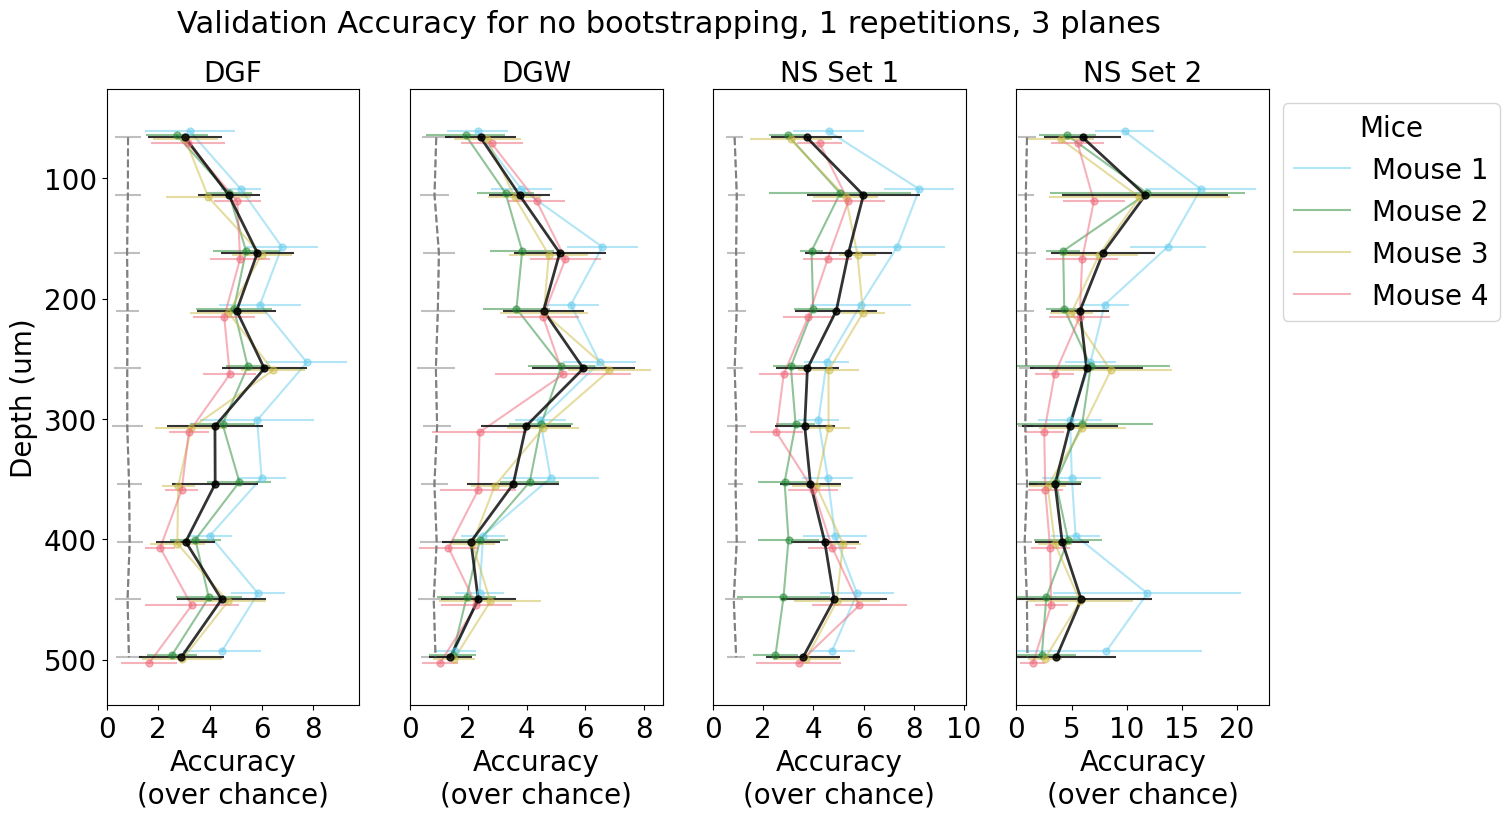

In [132]:
# Plot the results as a lineplot 

# Add some jitter to visualize the individual mice
jitter_amount = 5
jitter_step = jitter_amount * 2 / (n_mice - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, n_mice)
fixed_jitters = np.tile(jitter_values, (n_depths, 1))

titles = [
    'DGF',
    'DGW',
    'NS Set 1',
    'NS Set 2'
]

fontsize = 20

fig = plt.figure(figsize=(15, 8))


for stim_idx, stim_type in enumerate(stim_types):
    ax = plt.subplot(1, n_stims, stim_idx + 1)

    # Plot data
    for mouse_idx, mouse_id in enumerate(mice):
        mouse_color = mouse_colors[mouse_id]

        # Plot data
        means, std_errors = [], []
        
        for depth_idx, depth in enumerate(depths):
            data_values = val_data[stim_idx, mouse_idx, :, depth_idx, :]
            if np.all(np.isnan(data_values)):
                means.append(np.nan), std_errors.append(np.nan)
                continue

            mean = np.nanmean(data_values)
            std_error = np.nanstd(data_values)
            means.append(mean), std_errors.append(std_error)
        
        plt.errorbar(means, depths + fixed_jitters[:, mouse_idx], xerr=std_errors, fmt='o', color=mouse_color, label=mouse_id, capsize=0, markersize=5, alpha=0.5)
        plt.plot(means, depths + fixed_jitters[:, mouse_idx], color=mouse_color, linewidth=1.5, alpha=0.5)
    

    # Plot shuffled data (average over mice for visualization, so just need to iterate over depths)
    shuf_means, shuf_std_errors = [], []
    for depth_idx, depth in enumerate(depths):
        shuf_data_values = shuf_val_data[stim_idx, :, :, depth_idx, :]
        if np.all(np.isnan(shuf_data_values)):
            shuf_means.append(np.nan), shuf_std_errors.append(np.nan)
            continue
        shuf_mean = np.nanmean(shuf_data_values)
        shuf_std_error = np.nanstd(shuf_data_values)
        shuf_means.append(shuf_mean), shuf_std_errors.append(shuf_std_error)

    plt.errorbar(shuf_means, depths, xerr=shuf_std_errors, fmt='--', color='grey', label='Shuffled', capsize=0, alpha=0.5)
    plt.plot(shuf_means, depths, '--', color='grey', linewidth=1.5)

    # Plot overall averages 
    overall_means, overall_std_errors = [], []
    for depth_idx, depth in enumerate(depths):
        overall_data_values = val_data[stim_idx, :, :, depth_idx, :]
        if np.all(np.isnan(overall_data_values)):
            overall_means.append(np.nan), overall_std_errors.append(np.nan)
            continue
        overall_mean = np.nanmean(overall_data_values)
        overall_std_error = np.nanstd(overall_data_values)
        overall_means.append(overall_mean), overall_std_errors.append(overall_std_error)
    
    plt.errorbar(overall_means, depths, xerr=overall_std_errors, fmt='o', color='black', label='Overall Mean', capsize=0, alpha=0.8, markersize=5)
    plt.plot(overall_means, depths, '-', color='black', linewidth=2, alpha=0.8)

    if stim_idx == 0:
        plt.yticks(fontsize=fontsize)
        plt.ylabel('Depth (um)', fontsize=fontsize)
    elif stim_idx == n_stims - 1:
        plt.legend(['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], loc='upper left', bbox_to_anchor=(1, 1), title='Mice', fontsize=fontsize, title_fontsize=fontsize)
        plt.yticks([])
    else:
        plt.yticks([])

    ax.set_ylim(depths.min() - 40, depths.max() + 40)
    ax.set_xlim(left=0)
    ax.set_title(titles[stim_idx], fontsize=fontsize)
    ax.set_xlabel('Accuracy\n(over chance)', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.gca().invert_yaxis()

plt.suptitle(f'Validation Accuracy for no bootstrapping, {repetitions} repetitions, {num_planes} planes', fontsize=fontsize + 2)
# plt.tight_layout()
# plt.savefig(os.path.join(ARTIFACT_DIR, 'decoding_analyses', f'nobootstrapping_decoding_results.svg'), dpi=300)

Text(0.5, 0.98, 'Test Accuracy for no bootstrapping, 1 repetitions, 3 planes')

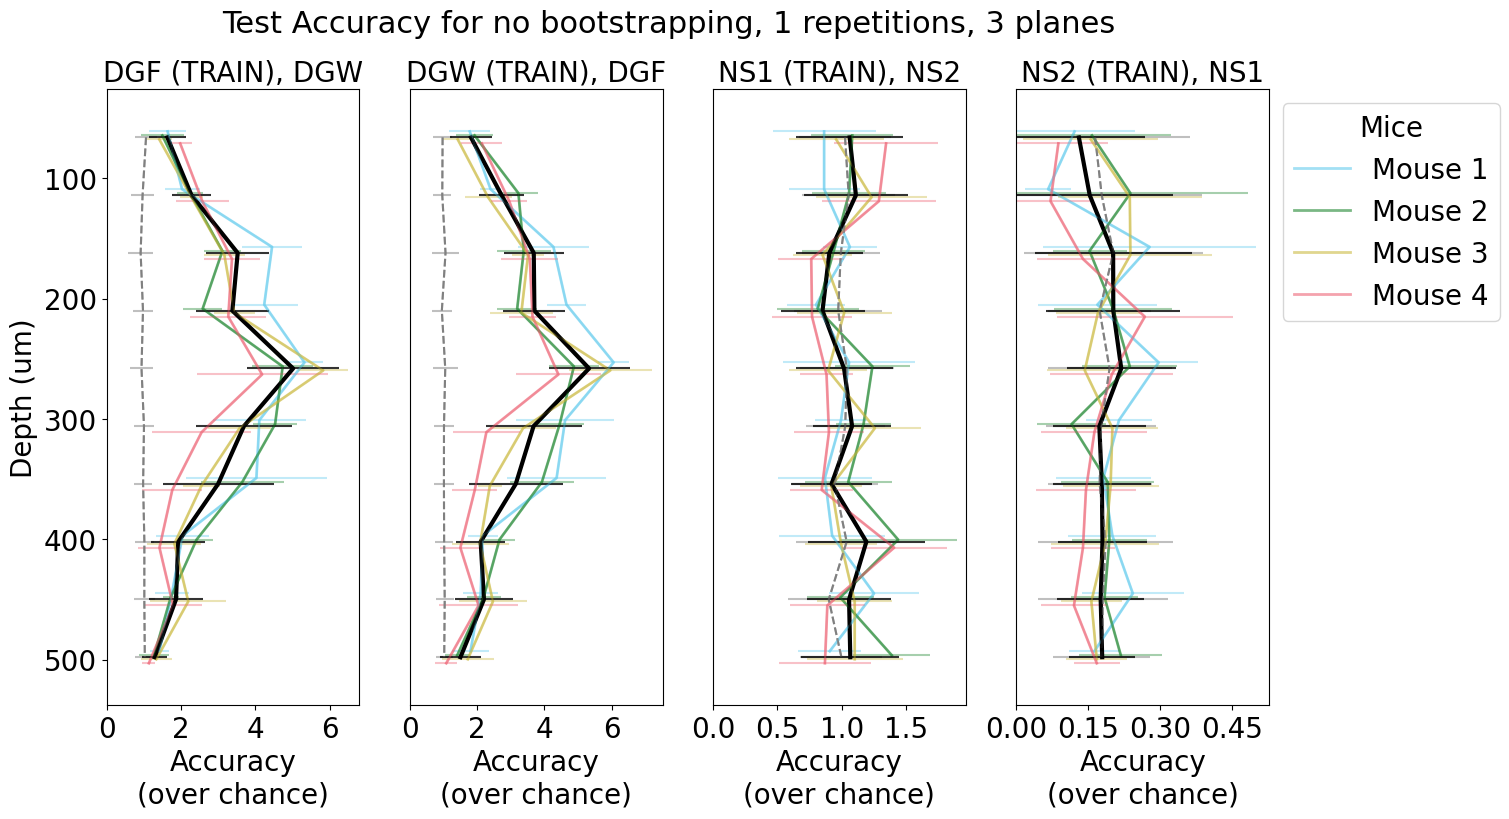

In [133]:
# Plot the results as a lineplot 

# Add some jitter to visualize the individual mice
jitter_amount = 5
jitter_step = jitter_amount * 2 / (n_mice - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, n_mice)
fixed_jitters = np.tile(jitter_values, (n_depths, 1))

title_format = "{stim_type} (TRAIN), {other_stim_type}"
stim_to_apprev = {
    "drifting_gratings_full": "DGF",
    "drifting_gratings_windowed": "DGW",
    "natural_images_12": "NS1",
    "natural_images": "NS2"
}

fontsize = 20

fig = plt.figure(figsize=(15, 8))


for stim_idx, stim_type in enumerate(stim_types):
    ax = plt.subplot(1, n_stims, stim_idx + 1)

    # Plot data
    for mouse_idx, mouse_id in enumerate(mice):
        mouse_color = mouse_colors[mouse_id]

        # Plot data
        means, std_errors = [], []
        
        for depth_idx, depth in enumerate(depths):
            data_values = test_data[stim_idx, mouse_idx, :, depth_idx, :]
            if np.all(np.isnan(data_values)):
                means.append(np.nan), std_errors.append(np.nan)
                continue

            mean = np.nanmean(data_values)
            std_error = np.nanstd(data_values)
            means.append(mean), std_errors.append(std_error)
        
        plt.errorbar(means, depths + fixed_jitters[:, mouse_idx], xerr=std_errors, fmt='-', color=mouse_color, label=mouse_id, capsize=0, alpha=0.4)
        plt.plot(means, depths + fixed_jitters[:, mouse_idx], '-', color=mouse_color, linewidth=2, alpha=0.6)
    

    # Plot shuffled data (average over mice for visualization, so just need to iterate over depths)
    shuf_means, shuf_std_errors = [], []
    for depth_idx, depth in enumerate(depths):
        shuf_data_values = shuf_test_data[stim_idx, :, :, depth_idx, :]
        if np.all(np.isnan(shuf_data_values)):
            shuf_means.append(np.nan), shuf_std_errors.append(np.nan)
            continue
        shuf_mean = np.nanmean(shuf_data_values)
        shuf_std_error = np.nanstd(shuf_data_values)
        shuf_means.append(shuf_mean), shuf_std_errors.append(shuf_std_error)

    plt.errorbar(shuf_means, depths, xerr=shuf_std_errors, fmt='--', color='grey', label='Shuffled', capsize=0, alpha=0.5)
    plt.plot(shuf_means, depths, '--', color='grey', linewidth=1.5)

    # Plot overall averages 
    overall_means, overall_std_errors = [], []
    for depth_idx, depth in enumerate(depths):
        overall_data_values = test_data[stim_idx, :, :, depth_idx, :]
        if np.all(np.isnan(overall_data_values)):
            overall_means.append(np.nan), overall_std_errors.append(np.nan)
            continue
        overall_mean = np.nanmean(overall_data_values)
        overall_std_error = np.nanstd(overall_data_values)
        overall_means.append(overall_mean), overall_std_errors.append(overall_std_error)
    
    plt.errorbar(overall_means, depths, xerr=overall_std_errors, fmt='-', color='black', label='Overall Mean', capsize=0, alpha=0.8)
    plt.plot(overall_means, depths, '-', color='black', linewidth=3)

    if stim_idx == 0:
        plt.yticks(fontsize=fontsize)
        plt.ylabel('Depth (um)', fontsize=fontsize)
    elif stim_idx == n_stims - 1:
        plt.legend(['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], loc='upper left', bbox_to_anchor=(1, 1), title='Mice', fontsize=fontsize, title_fontsize=fontsize)
        plt.yticks([])
    else:
        plt.yticks([])

    ax.set_ylim(depths.min() - 40, depths.max() + 40)
    ax.set_xlim(left=0)
    ax.set_title(title_format.format(stim_type=stim_to_apprev[stim_type], other_stim_type=stim_to_apprev[multi_stim_pairs[stim_type]]), fontsize=fontsize)
    ax.set_xlabel('Accuracy\n(over chance)', fontsize=fontsize)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    plt.xticks(fontsize=fontsize)
    plt.gca().invert_yaxis()

plt.suptitle(f'Test Accuracy for no bootstrapping, {repetitions} repetitions, {num_planes} planes', fontsize=fontsize + 2)

# plt.tight_layout()
# plt.savefig(os.path.join(ARTIFACT_DIR, 'decoding_analyses', f'nobootstrapping_decoding_results.svg'), dpi=300)

In [134]:
## Plot how the results are correlated with reliability 
metrics_df = pd.read_csv('/home/naomi/Desktop/data/all_metrics_240426.csv')
metrics_df.head()

,Unnamed: 0,orig_cell_index,mouse_id,valid_cell_index,cell_index,col_vol,column,volume,plane,x,...,dgf_pref_dir,dgw_pref_dir,dgf_osi,dgw_osi,dgf_dsi,dgw_dsi,dgf_ls,dgw_ls,ns12_ls,ns118_ls
0,0,8542,slc2,0,0,16,1,6,0,236,...,300,150,0.214924,0.485850,0.143261,0.394904,0.650162,0.670042,0.941426,0.943378
1,1,8543,slc2,1,1,16,1,6,0,159,...,300,90,0.765341,0.699801,0.934434,0.180604,0.914330,0.874348,0.962018,0.940841
2,2,8544,slc2,2,2,16,1,6,0,193,...,300,240,0.447789,0.317350,0.389030,0.267353,0.655039,0.657950,0.954018,0.956597
3,3,8545,slc2,3,3,16,1,6,0,230,...,210,0,0.661951,0.464806,0.056502,0.402281,0.667079,0.674886,0.944030,0.944862
4,4,8546,slc2,4,4,16,1,6,0,61,...,330,330,0.503441,0.748724,0.523120,1.000000,0.684561,0.845968,0.962426,0.954630


In [135]:
metrics_df.columns

Index(['Unnamed: 0', 'orig_cell_index', 'mouse_id', 'valid_cell_index',
       'cell_index', 'col_vol', 'column', 'volume', 'plane', 'x', 'y', 'z',
       '2p3p', 'frac_resp_on', 'frac_resp_off', 'frac_resp_ns12',
       'frac_resp_ns118', 'frac_resp_dgf', 'frac_resp_dgw', 'frac_resp_nm',
       'valid_not_duplicate', 'dgf_pref_dir', 'dgw_pref_dir', 'dgf_osi',
       'dgw_osi', 'dgf_dsi', 'dgw_dsi', 'dgf_ls', 'dgw_ls', 'ns12_ls',
       'ns118_ls'],
      dtype='object')

## NO BOOTSTRAPPING, 1 REPETITION, 1 PLANE

In [136]:
tag = "2025-08-08_3"
bootstrap_size = 1
repetitions = 1
num_planes = 1
all_results_df = pd.DataFrame()
for stim_type in stim_types:
    decode_dim = decode_dims[stim_type]
    other_stim_type = multi_stim_pairs[stim_type]

    path_name = f'/home/naomi/Desktop/data/decoding_results/{tag}_TRAIN{stim_type}_TEST{other_stim_type}_Boot{bootstrap_size}_Rep{repetitions}_NumPlanes{num_planes}'
    results_df = pd.DataFrame()
    for filename in os.listdir(path_name):
        f = os.path.join(path_name, filename)
        results_df = pd.concat([results_df, pd.read_pickle(f)])
    
    results_df['stim_type_training'] = stim_type
    results_df['stim_type_testing'] = other_stim_type
    results_df['decode_dim'] = decode_dim

    all_results_df = pd.concat([all_results_df, results_df], axis=0)

all_results_df['depth'] = all_results_df.apply(lambda x: depth_vol_mapping(vol_id = x['volume_id'], plane_id = x['plane_id']), axis=1)

In [137]:
# Organize data into 5D arrays
# one array for validation (val_data) and one for test (test_data) and the corresponding shuffled data (shuf_val_data, shuf_test_data)
# val_data corresponds to the accuracies on the same stimulus type as training (stim_type_train)
# test_data corresponds to the accuracies on the other stimulus type (stim_type_test)
# Dimensions: (stim_type_train, mouse_id, column_id, depth, folds)
# ** note that each stim_type_train has only one decode dim and one stim_type_test

folds = 5
mouse_ids = all_results_df.mouse_id.unique()
column_ids = all_results_df.column_id.unique()
depths = all_results_df.depth.unique()
depths = np.sort(depths)
stim_types = all_results_df.stim_type_training.unique()

n_depths = len(depths)
n_mice = len(mouse_ids)
n_columns = len(column_ids)
n_stims = len(stim_types)

val_data = np.zeros((n_stims, n_mice, n_columns, n_depths, folds))
shuf_val_data = np.zeros((n_stims, n_mice, n_columns, n_depths, folds))
test_data = np.zeros((n_stims, n_mice, n_columns, n_depths, folds))
shuf_test_data = np.zeros((n_stims, n_mice, n_columns, n_depths, folds))

for stim_idx, stim_type in enumerate(stim_types):
    for mouse_idx, mouse_id in enumerate(mouse_ids):
        for column_idx, column_id in enumerate(column_ids):
            for depth_idx, depth in enumerate(depths):
                    temp_df = all_results_df[
                        (all_results_df['stim_type_training'] == stim_type) &
                        (all_results_df['mouse_id'] == mouse_id) &
                        (all_results_df['column_id'] == column_id) &
                        (all_results_df['depth'] == depth)
                        ]
                    
                    # Note, these accuracies will be a list of 5 values, one for each fold
                    val_accuracies = temp_df.val_accuracy       
                    shuf_val_accuracies = temp_df.shuf_val_accuracy
                    test_accuracies = temp_df.test_accuracy      
                    shuf_test_accuracies = temp_df.shuf_test_accuracy

                    if len(val_accuracies) > 0:
                        val_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = val_accuracies.values[0]
                    else:
                        val_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = np.nan

                    if len(shuf_val_accuracies) > 0:
                        shuf_val_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = shuf_val_accuracies.values[0]
                    else:
                        shuf_val_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = np.nan
                    
                    if len(test_accuracies) > 0:
                        test_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = test_accuracies.values[0]
                    else:
                        test_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = np.nan
                    
                    if len(shuf_test_accuracies) > 0:
                        shuf_test_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = shuf_test_accuracies.values[0]
                    else:
                        shuf_test_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = np.nan

    # Normalize by chance
    val_data[stim_idx, :, :, :, :] /= chance[stim_type]
    shuf_val_data[stim_idx, :, :, :, :] /= chance[stim_type]
    test_data[stim_idx, :, :, :, :] /= chance[multi_stim_pairs[stim_type]]
    shuf_test_data[stim_idx, :, :, :, :] /= chance[multi_stim_pairs[stim_type]]

Text(0.5, 0.98, 'Validation Accuracy for no bootstrapping, 1 repetitions, 1 planes')

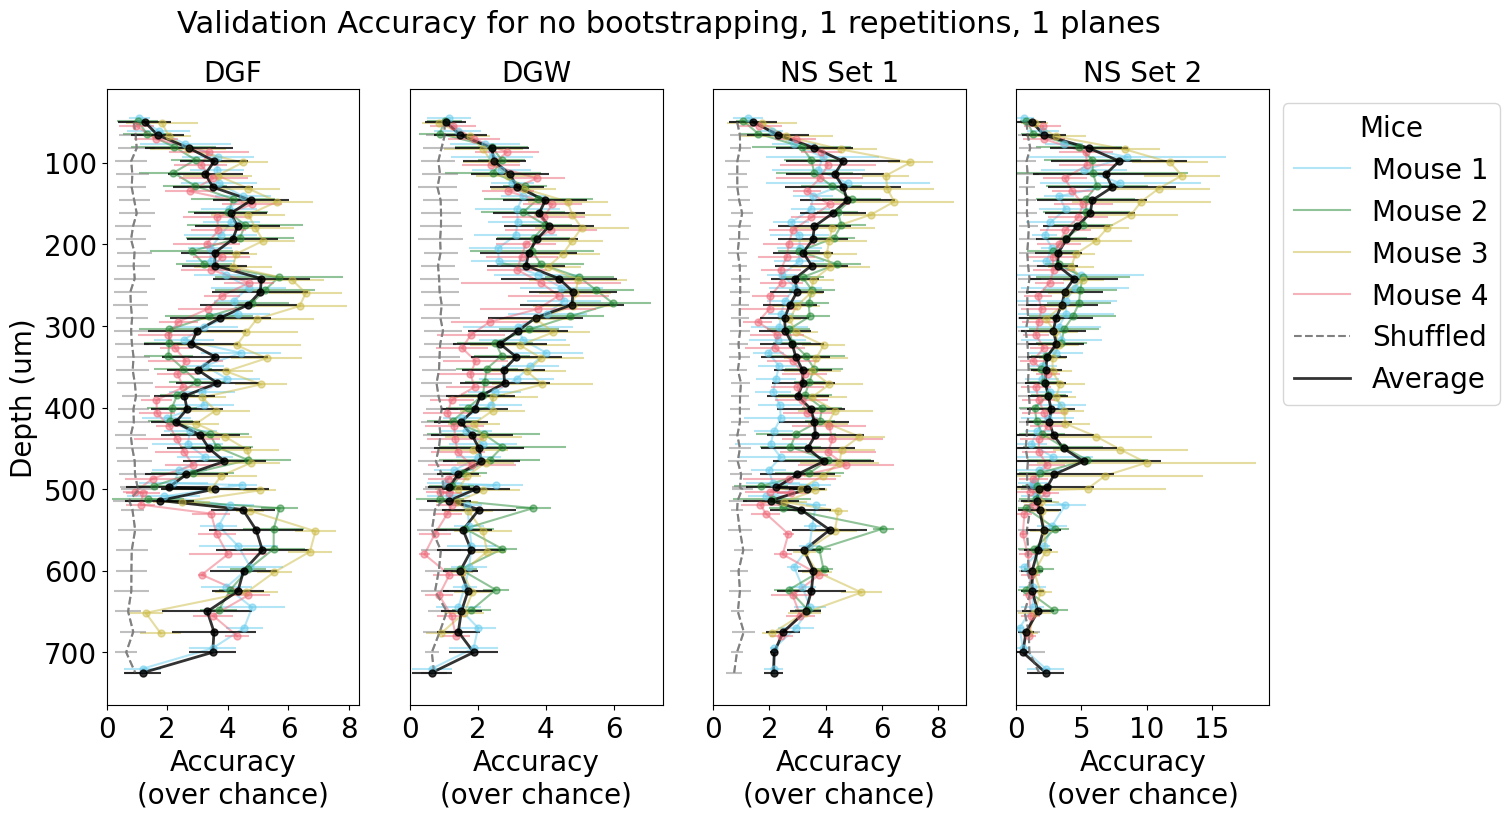

In [141]:
# Plot the results as a lineplot 

# Add some jitter to visualize the individual mice
jitter_amount = 5
jitter_step = jitter_amount * 2 / (n_mice - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, n_mice)
fixed_jitters = np.tile(jitter_values, (n_depths, 1))

titles = [
    'DGF',
    'DGW',
    'NS Set 1',
    'NS Set 2'
]

fontsize = 20

fig = plt.figure(figsize=(15, 8))


for stim_idx, stim_type in enumerate(stim_types):
    ax = plt.subplot(1, n_stims, stim_idx + 1)

    # Plot data
    for mouse_idx, mouse_id in enumerate(mice):
        mouse_color = mouse_colors[mouse_id]

        # Plot data
        means, std_errors = [], []
        
        for depth_idx, depth in enumerate(depths):
            data_values = val_data[stim_idx, mouse_idx, :, depth_idx, :]
            if np.all(np.isnan(data_values)):
                means.append(np.nan), std_errors.append(np.nan)
                continue

            mean = np.nanmean(data_values)
            std_error = np.nanstd(data_values)
            means.append(mean), std_errors.append(std_error)

        plt.errorbar(means, depths + fixed_jitters[:, mouse_idx], xerr=std_errors, fmt='o', color=mouse_color, label=mouse_id, capsize=0, alpha=0.5, markersize=5)
        plt.plot(means, depths + fixed_jitters[:, mouse_idx], color=mouse_color, linewidth=1.5, alpha=0.5)

    # Plot shuffled data (average over mice for visualization, so just need to iterate over depths)
    shuf_means, shuf_std_errors = [], []
    for depth_idx, depth in enumerate(depths):
        shuf_data_values = shuf_val_data[stim_idx, :, :, depth_idx, :]
        if np.all(np.isnan(shuf_data_values)):
            shuf_means.append(np.nan), shuf_std_errors.append(np.nan)
            continue
        shuf_mean = np.nanmean(shuf_data_values)
        shuf_std_error = np.nanstd(shuf_data_values)
        shuf_means.append(shuf_mean), shuf_std_errors.append(shuf_std_error)

    plt.errorbar(shuf_means, depths, xerr=shuf_std_errors, fmt='--', color='grey', label='Shuffled', capsize=0, alpha=0.5)
    plt.plot(shuf_means, depths, '--', color='grey', linewidth=1.5)

    # Plot overall averages 
    overall_means, overall_std_errors = [], []
    for depth_idx, depth in enumerate(depths):
        overall_data_values = val_data[stim_idx, :, :, depth_idx, :]
        if np.all(np.isnan(overall_data_values)):
            overall_means.append(np.nan), overall_std_errors.append(np.nan)
            continue
        overall_mean = np.nanmean(overall_data_values)
        overall_std_error = np.nanstd(overall_data_values)
        overall_means.append(overall_mean), overall_std_errors.append(overall_std_error)

    plt.errorbar(overall_means, depths, xerr=overall_std_errors, fmt='o', color='black', label='Overall Mean', capsize=0, alpha=0.8, markersize=5)
    plt.plot(overall_means, depths, '-', color='black', linewidth=2, alpha=0.8)

    if stim_idx == 0:
        plt.yticks(fontsize=fontsize)
        plt.ylabel('Depth (um)', fontsize=fontsize)
    elif stim_idx == n_stims - 1:
        plt.legend(['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4', 'Shuffled', 'Average'], loc='upper left', bbox_to_anchor=(1, 1), title='Mice', fontsize=fontsize, title_fontsize=fontsize)
        plt.yticks([])
    else:
        plt.yticks([])

    ax.set_ylim(depths.min() - 40, depths.max() + 40)
    ax.set_xlim(left=0)
    ax.set_title(titles[stim_idx], fontsize=fontsize)
    ax.set_xlabel('Accuracy\n(over chance)', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.gca().invert_yaxis()

plt.suptitle(f'Validation Accuracy for no bootstrapping, {repetitions} repetitions, {num_planes} planes', fontsize=fontsize + 2)
# plt.tight_layout()
# plt.savefig(os.path.join(ARTIFACT_DIR, 'decoding_analyses', f'nobootstrapping_decoding_results.svg'), dpi=300)

Text(0.5, 0.98, 'Test Accuracy for no bootstrapping, 1 repetitions, 1 planes')

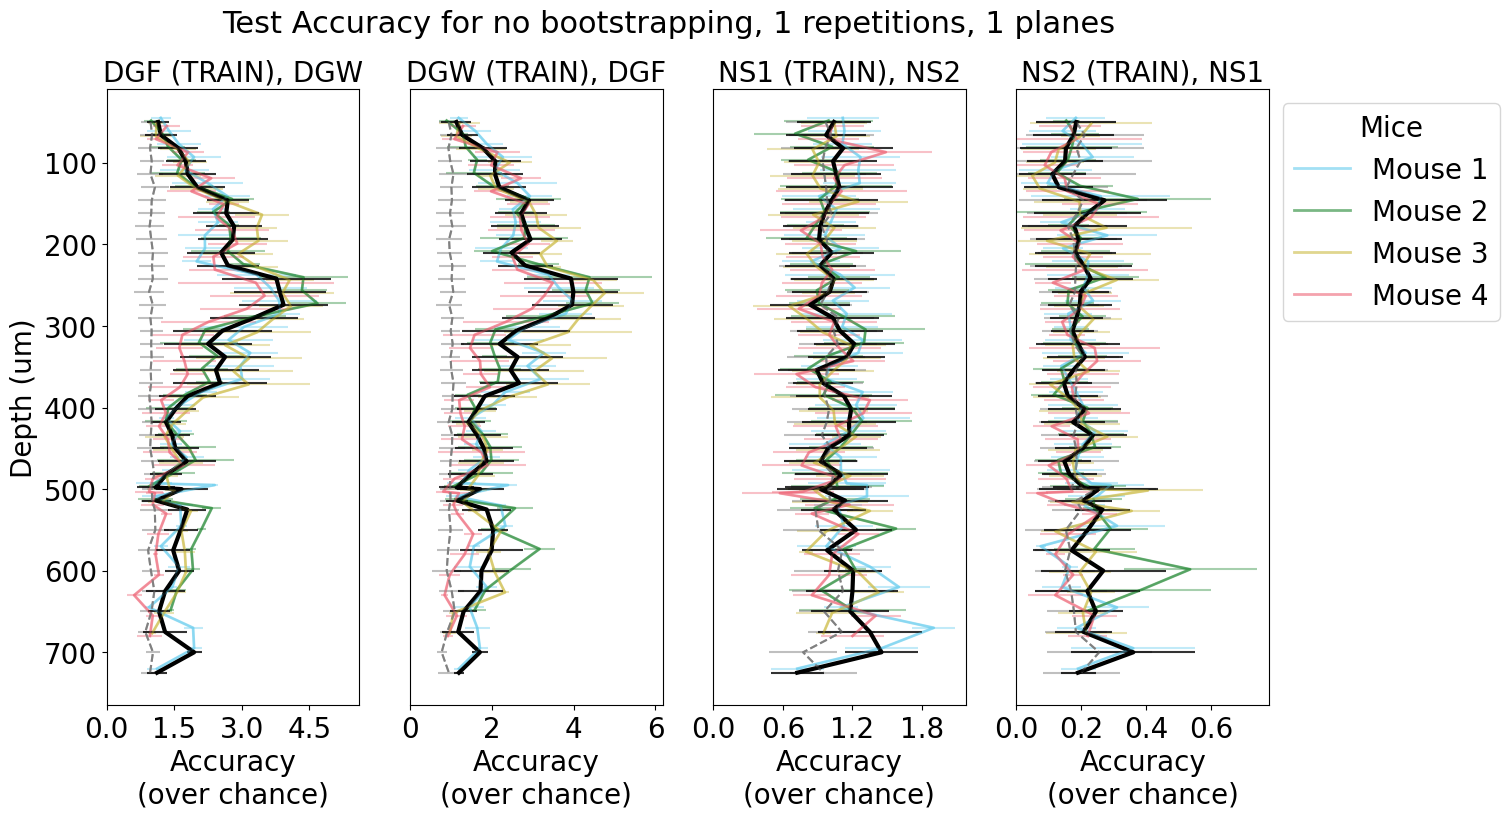

In [119]:
# Plot the results as a lineplot 

# Add some jitter to visualize the individual mice
jitter_amount = 5
jitter_step = jitter_amount * 2 / (n_mice - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, n_mice)
fixed_jitters = np.tile(jitter_values, (n_depths, 1))

title_format = "{stim_type} (TRAIN), {other_stim_type}"
stim_to_apprev = {
    "drifting_gratings_full": "DGF",
    "drifting_gratings_windowed": "DGW",
    "natural_images_12": "NS1",
    "natural_images": "NS2"
}

fontsize = 20

fig = plt.figure(figsize=(15, 8))


for stim_idx, stim_type in enumerate(stim_types):
    ax = plt.subplot(1, n_stims, stim_idx + 1)

    # Plot data
    for mouse_idx, mouse_id in enumerate(mice):
        mouse_color = mouse_colors[mouse_id]

        # Plot data
        means, std_errors = [], []
        
        for depth_idx, depth in enumerate(depths):
            data_values = test_data[stim_idx, mouse_idx, :, depth_idx, :]
            if np.all(np.isnan(data_values)):
                means.append(np.nan), std_errors.append(np.nan)
                continue

            mean = np.nanmean(data_values)
            std_error = np.nanstd(data_values)
            means.append(mean), std_errors.append(std_error)
        
        plt.errorbar(means, depths + fixed_jitters[:, mouse_idx], xerr=std_errors, fmt='-', color=mouse_color, label=mouse_id, capsize=0, alpha=0.4)
        plt.plot(means, depths + fixed_jitters[:, mouse_idx], '-', color=mouse_color, linewidth=2, alpha=0.6)
    

    # Plot shuffled data (average over mice for visualization, so just need to iterate over depths)
    shuf_means, shuf_std_errors = [], []
    for depth_idx, depth in enumerate(depths):
        shuf_data_values = shuf_test_data[stim_idx, :, :, depth_idx, :]
        if np.all(np.isnan(shuf_data_values)):
            shuf_means.append(np.nan), shuf_std_errors.append(np.nan)
            continue
        shuf_mean = np.nanmean(shuf_data_values)
        shuf_std_error = np.nanstd(shuf_data_values)
        shuf_means.append(shuf_mean), shuf_std_errors.append(shuf_std_error)

    plt.errorbar(shuf_means, depths, xerr=shuf_std_errors, fmt='--', color='grey', label='Shuffled', capsize=0, alpha=0.5)
    plt.plot(shuf_means, depths, '--', color='grey', linewidth=1.5)

    # Plot overall averages 
    overall_means, overall_std_errors = [], []
    for depth_idx, depth in enumerate(depths):
        overall_data_values = test_data[stim_idx, :, :, depth_idx, :]
        if np.all(np.isnan(overall_data_values)):
            overall_means.append(np.nan), overall_std_errors.append(np.nan)
            continue
        overall_mean = np.nanmean(overall_data_values)
        overall_std_error = np.nanstd(overall_data_values)
        overall_means.append(overall_mean), overall_std_errors.append(overall_std_error)
    
    plt.errorbar(overall_means, depths, xerr=overall_std_errors, fmt='-', color='black', label='Overall Mean', capsize=0, alpha=0.8)
    plt.plot(overall_means, depths, '-', color='black', linewidth=3)

    if stim_idx == 0:
        plt.yticks(fontsize=fontsize)
        plt.ylabel('Depth (um)', fontsize=fontsize)
    elif stim_idx == n_stims - 1:
        plt.legend(['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], loc='upper left', bbox_to_anchor=(1, 1), title='Mice', fontsize=fontsize, title_fontsize=fontsize)
        plt.yticks([])
    else:
        plt.yticks([])

    ax.set_ylim(depths.min() - 40, depths.max() + 40)
    ax.set_xlim(left=0)
    ax.set_title(title_format.format(stim_type=stim_to_apprev[stim_type], other_stim_type=stim_to_apprev[multi_stim_pairs[stim_type]]), fontsize=fontsize)
    ax.set_xlabel('Accuracy\n(over chance)', fontsize=fontsize)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    plt.xticks(fontsize=fontsize)
    plt.gca().invert_yaxis()

plt.suptitle(f'Test Accuracy for no bootstrapping, {repetitions} repetitions, {num_planes} planes', fontsize=fontsize + 2)

# plt.tight_layout()
# plt.savefig(os.path.join(ARTIFACT_DIR, 'decoding_analyses', f'nobootstrapping_decoding_results.svg'), dpi=300)

## YES BOOTSTRAPPING, 1000 REPETITIONS, 3 PLANES

#### these results will take a little longer to run given there are 1000 repetitions for each decoding experiment...

In [115]:
## took 2 minutes, 12.7 seconds to run
tag = "2025-08-08_2"
bootstrap_size = 250
repetitions = 1000
num_planes = 3
all_results_df = pd.DataFrame()
for stim_type in stim_types:
    decode_dim = decode_dims[stim_type]
    other_stim_type = multi_stim_pairs[stim_type]

    path_name = f'/home/naomi/Desktop/data/decoding_results/{tag}_TRAIN{stim_type}_TEST{other_stim_type}_Boot{bootstrap_size}_Rep{repetitions}_NumPlanes{num_planes}'
    results_df = pd.DataFrame()
    for filename in os.listdir(path_name):
        f = os.path.join(path_name, filename)
        results_df = pd.concat([results_df, pd.read_pickle(f)])
    
    results_df['stim_type_training'] = stim_type
    results_df['stim_type_testing'] = other_stim_type
    results_df['decode_dim'] = decode_dim

    all_results_df = pd.concat([all_results_df, results_df], axis=0)

all_results_df['depth'] = all_results_df.apply(lambda x: depth_vol_mapping(vol_id = x['volume_id'], plane_id = x['plane_id']), axis=1)

In [ ]:
# Organize data into 5D arrays
# one array for validation (val_data) and one for test (test_data) and the corresponding shuffled data (shuf_val_data, shuf_test_data)
# val_data corresponds to the accuracies on the same stimulus type as training (stim_type_train)
# test_data corresponds to the accuracies on the other stimulus type (stim_type_test)
# Dimensions: (stim_type_train, mouse_id, column_id, depth, folds)
# ** note that each stim_type_train has only one decode dim and one stim_type_test

folds = 5
mouse_ids = all_results_df.mouse_id.unique()
column_ids = all_results_df.column_id.unique()
depths = all_results_df.depth.unique()
depths = np.sort(depths)
stim_types = all_results_df.stim_type_training.unique()

n_depths = len(depths)
n_mice = len(mouse_ids)
n_columns = len(column_ids)
n_stims = len(stim_types)

val_data = np.zeros((n_stims, n_mice, n_columns, n_depths, folds))
shuf_val_data = np.zeros((n_stims, n_mice, n_columns, n_depths, folds))
test_data = np.zeros((n_stims, n_mice, n_columns, n_depths, folds))
shuf_test_data = np.zeros((n_stims, n_mice, n_columns, n_depths, folds))

for stim_idx, stim_type in enumerate(stim_types):
    for mouse_idx, mouse_id in enumerate(mouse_ids):
        for column_idx, column_id in enumerate(column_ids):
            for depth_idx, depth in enumerate(depths):
                    temp_df = all_results_df[
                        (all_results_df['stim_type_training'] == stim_type) &
                        (all_results_df['mouse_id'] == mouse_id) &
                        (all_results_df['column_id'] == column_id) &
                        (all_results_df['depth'] == depth)
                        ]
                    
                    # Note, these accuracies will be a list of 5 values, one for each fold
                    val_accuracies = temp_df.val_accuracy       
                    shuf_val_accuracies = temp_df.shuf_val_accuracy
                    test_accuracies = temp_df.test_accuracy      
                    shuf_test_accuracies = temp_df.shuf_test_accuracy

                    if len(val_accuracies) > 0:
                        val_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = val_accuracies.values[0]
                    else:
                        val_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = np.nan

                    if len(shuf_val_accuracies) > 0:
                        shuf_val_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = shuf_val_accuracies.values[0]
                    else:
                        shuf_val_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = np.nan
                    
                    if len(test_accuracies) > 0:
                        test_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = test_accuracies.values[0]
                    else:
                        test_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = np.nan
                    
                    if len(shuf_test_accuracies) > 0:
                        shuf_test_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = shuf_test_accuracies.values[0]
                    else:
                        shuf_test_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = np.nan

    # Normalize by chance
    val_data[stim_idx, :, :, :, :] /= chance[stim_type]
    shuf_val_data[stim_idx, :, :, :, :] /= chance[stim_type]
    test_data[stim_idx, :, :, :, :] /= chance[multi_stim_pairs[stim_type]]
    shuf_test_data[stim_idx, :, :, :, :] /= chance[multi_stim_pairs[stim_type]]

Text(0.5, 0.98, 'Validation Accuracy with bootstrapping, 1000 repetitions, 3 planes')

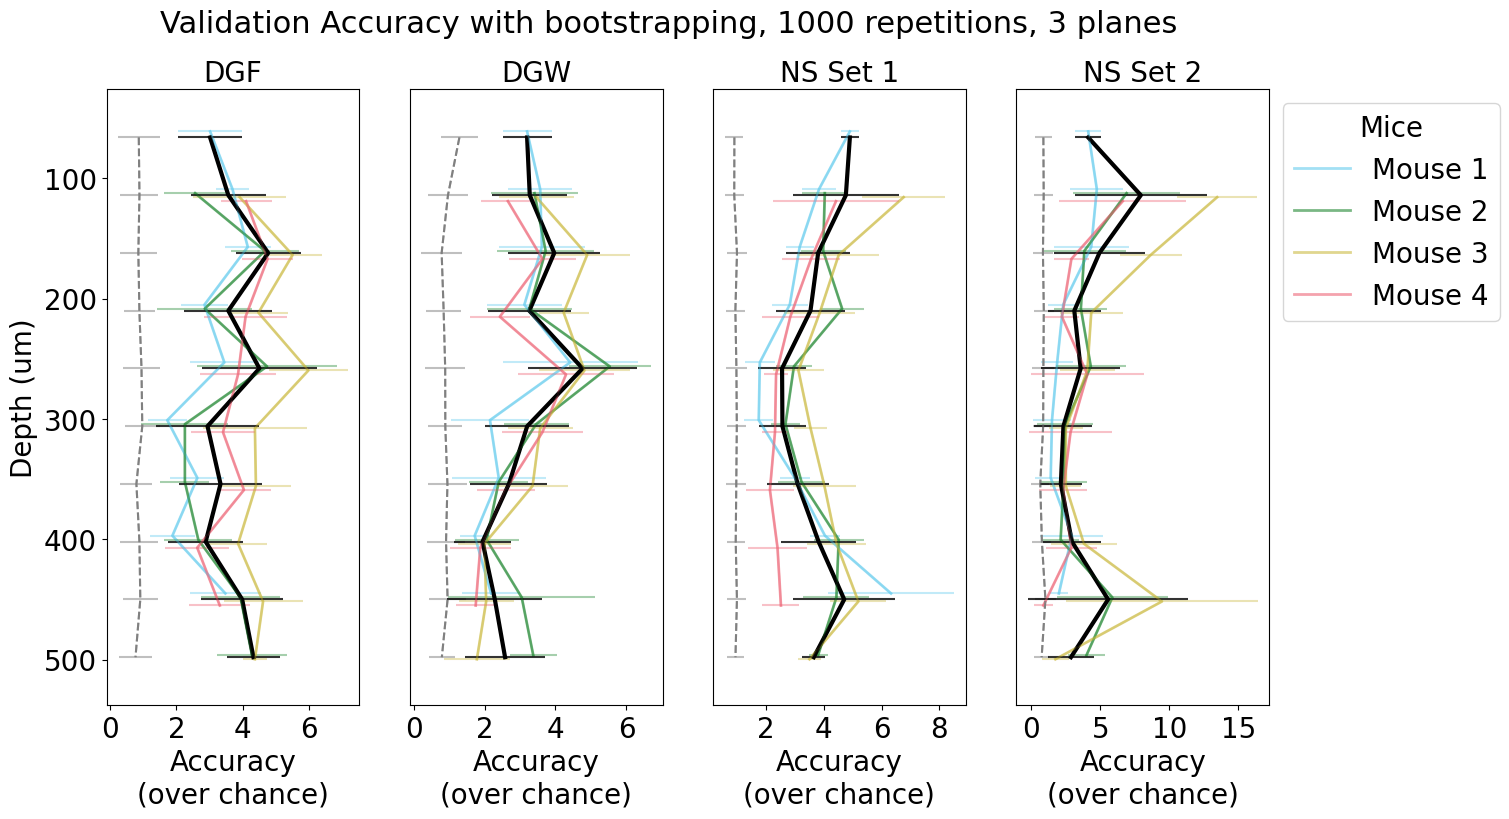

In [ ]:
# Plot the results as a lineplot 

# Add some jitter to visualize the individual mice
jitter_amount = 5
jitter_step = jitter_amount * 2 / (n_mice - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, n_mice)
fixed_jitters = np.tile(jitter_values, (n_depths, 1))

titles = [
    'DGF',
    'DGW',
    'NS Set 1',
    'NS Set 2'
]

fontsize = 20

fig = plt.figure(figsize=(15, 8))


for stim_idx, stim_type in enumerate(stim_types):
    ax = plt.subplot(1, n_stims, stim_idx + 1)

    # Plot data
    for mouse_idx, mouse_id in enumerate(mice):
        mouse_color = mouse_colors[mouse_id]

        # Plot data
        means, std_errors = [], []
        
        for depth_idx, depth in enumerate(depths):
            data_values = val_data[stim_idx, mouse_idx, :, depth_idx, :]
            if np.all(np.isnan(data_values)):
                means.append(np.nan), std_errors.append(np.nan)
                continue

            mean = np.nanmean(data_values)
            std_error = np.nanstd(data_values)
            means.append(mean), std_errors.append(std_error)
        
        plt.errorbar(means, depths + fixed_jitters[:, mouse_idx], xerr=std_errors, fmt='-', color=mouse_color, label=mouse_id, capsize=0, alpha=0.4)
        plt.plot(means, depths + fixed_jitters[:, mouse_idx], '-', color=mouse_color, linewidth=2, alpha=0.6)
    

    # Plot shuffled data (average over mice for visualization, so just need to iterate over depths)
    shuf_means, shuf_std_errors = [], []
    for depth_idx, depth in enumerate(depths):
        shuf_data_values = shuf_val_data[stim_idx, :, :, depth_idx, :]
        if np.all(np.isnan(shuf_data_values)):
            shuf_means.append(np.nan), shuf_std_errors.append(np.nan)
            continue
        shuf_mean = np.nanmean(shuf_data_values)
        shuf_std_error = np.nanstd(shuf_data_values)
        shuf_means.append(shuf_mean), shuf_std_errors.append(shuf_std_error)

    plt.errorbar(shuf_means, depths, xerr=shuf_std_errors, fmt='--', color='grey', label='Shuffled', capsize=0, alpha=0.5)
    plt.plot(shuf_means, depths, '--', color='grey', linewidth=1.5)

    # Plot overall averages 
    overall_means, overall_std_errors = [], []
    for depth_idx, depth in enumerate(depths):
        overall_data_values = val_data[stim_idx, :, :, depth_idx, :]
        if np.all(np.isnan(overall_data_values)):
            overall_means.append(np.nan), overall_std_errors.append(np.nan)
            continue
        overall_mean = np.nanmean(overall_data_values)
        overall_std_error = np.nanstd(overall_data_values)
        overall_means.append(overall_mean), overall_std_errors.append(overall_std_error)
    
    plt.errorbar(overall_means, depths, xerr=overall_std_errors, fmt='-', color='black', label='Overall Mean', capsize=0, alpha=0.8)
    plt.plot(overall_means, depths, '-', color='black', linewidth=3)

    if stim_idx == 0:
        plt.yticks(fontsize=fontsize)
        plt.ylabel('Depth (um)', fontsize=fontsize)
    elif stim_idx == n_stims - 1:
        plt.legend(['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], loc='upper left', bbox_to_anchor=(1, 1), title='Mice', fontsize=fontsize, title_fontsize=fontsize)
        plt.yticks([])
    else:
        plt.yticks([])

    ax.set_ylim(depths.min() - 40, depths.max() + 40)
    ax.set_xlim(left=0)
    ax.set_title(titles[stim_idx], fontsize=fontsize)
    ax.set_xlabel('Accuracy\n(over chance)', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.gca().invert_yaxis()

plt.suptitle(f'Validation Accuracy with bootstrapping, {repetitions} repetitions, {num_planes} planes', fontsize=fontsize + 2)
# plt.tight_layout()
# plt.savefig(os.path.join(ARTIFACT_DIR, 'decoding_analyses', f'nobootstrapping_decoding_results.svg'), dpi=300)

Text(0.5, 0.98, 'Test Accuracy with bootstrapping, 1000 repetitions, 3 planes')

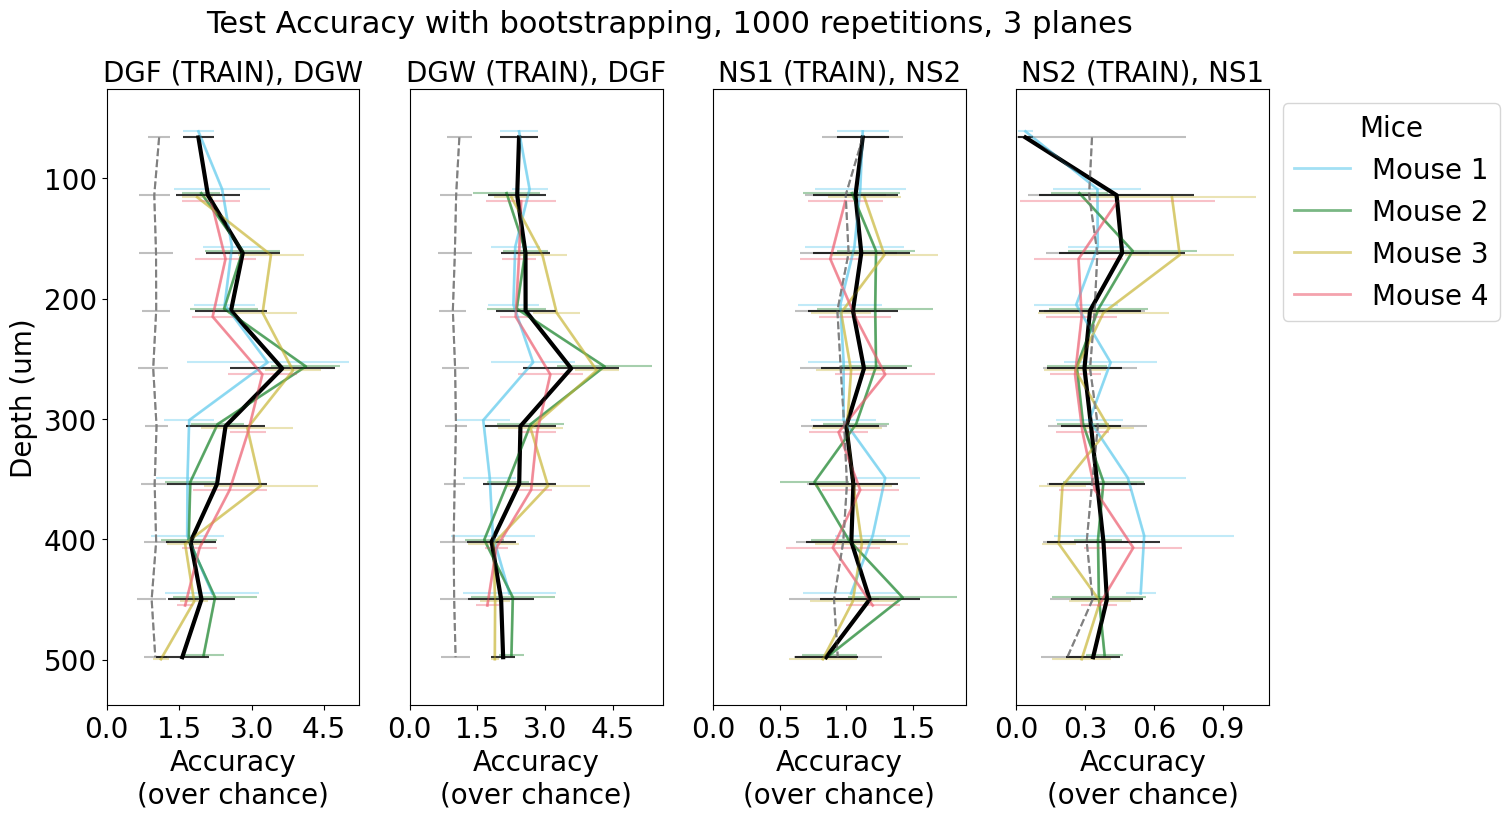

In [ ]:
# Plot the results as a lineplot 

# Add some jitter to visualize the individual mice
jitter_amount = 5
jitter_step = jitter_amount * 2 / (n_mice - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, n_mice)
fixed_jitters = np.tile(jitter_values, (n_depths, 1))

title_format = "{stim_type} (TRAIN), {other_stim_type}"
stim_to_apprev = {
    "drifting_gratings_full": "DGF",
    "drifting_gratings_windowed": "DGW",
    "natural_images_12": "NS1",
    "natural_images": "NS2"
}

fontsize = 20

fig = plt.figure(figsize=(15, 8))


for stim_idx, stim_type in enumerate(stim_types):
    ax = plt.subplot(1, n_stims, stim_idx + 1)

    # Plot data
    for mouse_idx, mouse_id in enumerate(mice):
        mouse_color = mouse_colors[mouse_id]

        # Plot data
        means, std_errors = [], []
        
        for depth_idx, depth in enumerate(depths):
            data_values = test_data[stim_idx, mouse_idx, :, depth_idx, :]
            if np.all(np.isnan(data_values)):
                means.append(np.nan), std_errors.append(np.nan)
                continue

            mean = np.nanmean(data_values)
            std_error = np.nanstd(data_values)
            means.append(mean), std_errors.append(std_error)
        
        plt.errorbar(means, depths + fixed_jitters[:, mouse_idx], xerr=std_errors, fmt='-', color=mouse_color, label=mouse_id, capsize=0, alpha=0.4)
        plt.plot(means, depths + fixed_jitters[:, mouse_idx], '-', color=mouse_color, linewidth=2, alpha=0.6)
    

    # Plot shuffled data (average over mice for visualization, so just need to iterate over depths)
    shuf_means, shuf_std_errors = [], []
    for depth_idx, depth in enumerate(depths):
        shuf_data_values = shuf_test_data[stim_idx, :, :, depth_idx, :]
        if np.all(np.isnan(shuf_data_values)):
            shuf_means.append(np.nan), shuf_std_errors.append(np.nan)
            continue
        shuf_mean = np.nanmean(shuf_data_values)
        shuf_std_error = np.nanstd(shuf_data_values)
        shuf_means.append(shuf_mean), shuf_std_errors.append(shuf_std_error)

    plt.errorbar(shuf_means, depths, xerr=shuf_std_errors, fmt='--', color='grey', label='Shuffled', capsize=0, alpha=0.5)
    plt.plot(shuf_means, depths, '--', color='grey', linewidth=1.5)

    # Plot overall averages 
    overall_means, overall_std_errors = [], []
    for depth_idx, depth in enumerate(depths):
        overall_data_values = test_data[stim_idx, :, :, depth_idx, :]
        if np.all(np.isnan(overall_data_values)):
            overall_means.append(np.nan), overall_std_errors.append(np.nan)
            continue
        overall_mean = np.nanmean(overall_data_values)
        overall_std_error = np.nanstd(overall_data_values)
        overall_means.append(overall_mean), overall_std_errors.append(overall_std_error)
    
    plt.errorbar(overall_means, depths, xerr=overall_std_errors, fmt='-', color='black', label='Overall Mean', capsize=0, alpha=0.8)
    plt.plot(overall_means, depths, '-', color='black', linewidth=3)

    if stim_idx == 0:
        plt.yticks(fontsize=fontsize)
        plt.ylabel('Depth (um)', fontsize=fontsize)
    elif stim_idx == n_stims - 1:
        plt.legend(['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], loc='upper left', bbox_to_anchor=(1, 1), title='Mice', fontsize=fontsize, title_fontsize=fontsize)
        plt.yticks([])
    else:
        plt.yticks([])

    ax.set_ylim(depths.min() - 40, depths.max() + 40)
    ax.set_xlim(left=0)
    ax.set_title(title_format.format(stim_type=stim_to_apprev[stim_type], other_stim_type=stim_to_apprev[multi_stim_pairs[stim_type]]), fontsize=fontsize)
    ax.set_xlabel('Accuracy\n(over chance)', fontsize=fontsize)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    plt.xticks(fontsize=fontsize)
    plt.gca().invert_yaxis()

plt.suptitle(f'Test Accuracy with bootstrapping, {repetitions} repetitions, {num_planes} planes', fontsize=fontsize + 2)

# plt.tight_layout()
# plt.savefig(os.path.join(ARTIFACT_DIR, 'decoding_analyses', f'nobootstrapping_decoding_results.svg'), dpi=300)

### 3: decoding schematic

In [ ]:
import sys
sys.path.insert(0, '/home/naomi/Desktop/code/v1dd-public/analysis-runner')
import decoding
from allen_v1dd.client import OPhysClient
from pathlib import Path

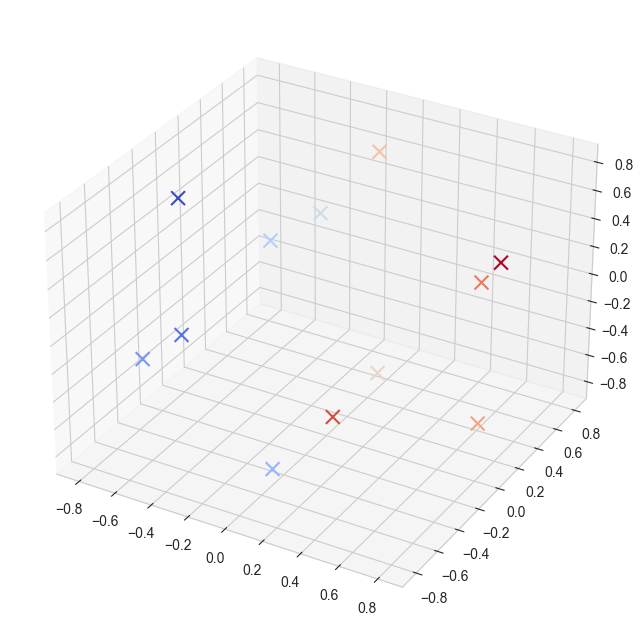

In [ ]:
## Figuring out how to simulate the 3D scatter plot of the icosahedron centers (to simulate different locations of the trial identities)

fig, axs = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': '3d'})
sns.set_style("whitegrid")

icosahedron = (1 + np.math.sqrt(5)) / 2  # Golden ratio
centers = [
    (1, icosahedron, 0),
    (-1, icosahedron, 0),
    (1, -icosahedron, 0),
    (-1, -icosahedron, 0),
    (0, 1, icosahedron),
    (0, -1, icosahedron),
    (0, 1, -icosahedron),
    (0, -1, -icosahedron),
    (icosahedron, 0, 1),
    (-icosahedron, 0, 1),
    (icosahedron, 0, -1),
    (-icosahedron, 0, -1)
]
import math
from itertools import combinations

def euclidean_distance(p1, p2):
    return math.sqrt(sum((c1 - c2)**2 for c1, c2 in zip(p1, p2)))

def sort_by_pairwise_distance(arr):
    distances = []
    for p1, p2 in combinations(arr, 2):
        distances.append((euclidean_distance(p1, p2), p1, p2))
    # Sort points by distance
    distances.sort()
    sorted_points = []
    for d, p1, p2 in distances:
        if p1 not in sorted_points:
            sorted_points.append(p1)
        if p2 not in sorted_points:
            sorted_points.append(p2)
    return sorted_points

sorted_centers = sort_by_pairwise_distance(centers)

sorted_centers_arr = np.zeros((len(sorted_centers), 3))
for i, (x, y, z) in enumerate(sorted_centers):
    sorted_centers_arr[i] = [x, y, z]
sorted_centers_arr /= 2  # Normalize to fit in the unit cube

centers_orientations = np.linspace(0, 330, 12)
axs.scatter(sorted_centers_arr[:, 0], sorted_centers_arr[:, 1], sorted_centers_arr[:, 2], c=centers_orientations, cmap='coolwarm', marker='x', s=100, alpha=1)

Closest points: [18 17 14], Distances: [0.40659453 0.46620756 0.5492262 ], Orientations: [330. 330. 180.]


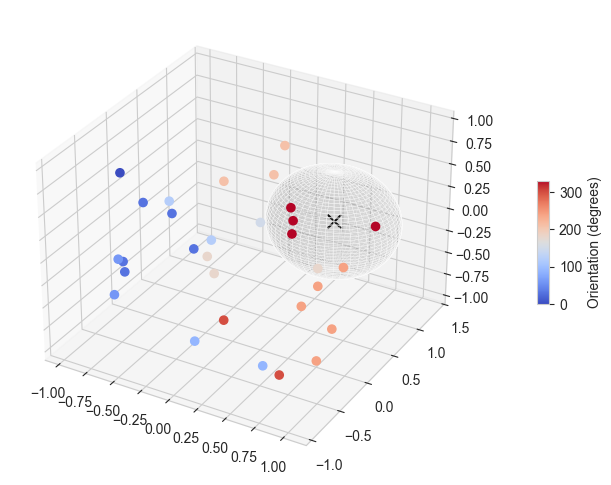

In [ ]:
## Plot sample 3d schematic of a KNN
# each point represents a single trial, with the color represeenting the direction of the drifting grating of that trial
# x, y, z represent the activity of 3 neurons during that trial 

np.random.seed(9)

fig, axs = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': '3d'})
sns.set_style("whitegrid")

# Create some sample data
n=30
lower_bound = -1
upper_bound = 1
x_values = (upper_bound - lower_bound) * np.random.rand(n) + lower_bound
y_values = (upper_bound - lower_bound) * np.random.rand(n) + lower_bound
z_values = (upper_bound - lower_bound) * np.random.rand(n) + lower_bound

orientations = np.zeros(n)

for i, (x, y, z) in enumerate(zip(x_values, y_values, z_values)):
    distances = []
    # Calculate distances from each center and find closest center
    for center in sorted_centers_arr:
        distances.append(math.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2))
    closest_orientation = centers_orientations[np.where(np.min(distances) == distances)[0][0]]
    orientations[i] = closest_orientation

sc = axs.scatter(x_values, y_values, z_values, c=orientations, cmap='coolwarm', marker='o', s=35, alpha=1)
plt.colorbar(sc, ax=axs, label='Orientation (degrees)', pad=0.1, aspect=10, shrink=0.2)

# test point
pt = (1/2, icosahedron/2, 0)
distances = []
for i, (x, y, z) in enumerate(zip(x_values, y_values, z_values)):
    distances.append(math.sqrt((x - pt[0])**2 + (y - pt[1])**2 + (z - pt[2])**2))

k_neighbors = 3
closest_indices = np.argsort(distances)[:k_neighbors]
closest_distances = np.array(distances)[closest_indices]
closest_orientations = orientations[closest_indices]
# closest_points = np.array([x_values[closest_indices], y_values[closest_indices], z_values[closest_indices]]).T
print(f"Closest points: {closest_indices}, Distances: {closest_distances}, Orientations: {closest_orientations}")

axs.scatter(pt[0], pt[1], pt[2], c='black', marker='x', s=100, alpha=1)

theta = np.linspace(0, 2 * np.pi, 1000)
phi = np.linspace(0, np.pi, 1000)
theta, phi = np.meshgrid(theta, phi)
r = np.max(closest_distances)  # Use the maximum distance to plot the surface
x_surface = r * np.sin(phi) * np.cos(theta) + pt[0]
y_surface = r * np.sin(phi) * np.sin(theta) + pt[1]
z_surface = r * np.cos(phi) + pt[2]

axs.plot_surface(x_surface, y_surface, z_surface, color='grey', alpha=0.1, linewidth=0.2)

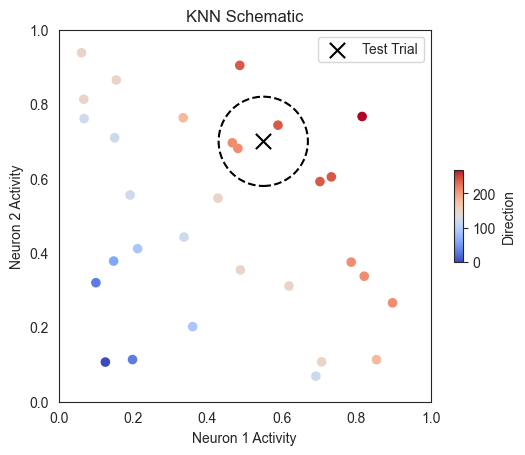

In [ ]:
## 2d version of the same plot
fig, ax = plt.subplots(figsize=(6, 6))
# sns.set_style("whitegrid")
sns.set_style("white")
np.random.seed(11)

# Create some sample data
n = 30
lower_bound = 0.05
upper_bound = 0.95
x_values = (np.random.rand(n) * (upper_bound - lower_bound) + lower_bound)
y_values = (np.random.rand(n) * (upper_bound - lower_bound) + lower_bound)

x_bins = np.linspace(lower_bound, upper_bound, 8)  # 12 bins for the 12 orientations
y_bins = np.linspace(lower_bound, upper_bound, 7)  # Same bins for y values
x_indices = np.digitize(x_values, x_bins) - 1  # Get bin indices for x values
y_indices = np.digitize(y_values, y_bins) - 1  # Get bin indices for y values

# Create orientations based on the bin indices
orientations = (x_indices + y_indices) % 12 * 30  # Example orientations based on x and y indices
# orientations = (x_values + y_values) * 360  # Example orientations based on x and y values

sc = ax.scatter(x_values, y_values, c=orientations, cmap='coolwarm', marker='o', s=35, alpha=1)
plt.colorbar(sc, ax=ax, label='Direction', aspect=10, shrink=0.2, location='right')

test_pt = (0.55, 0.7)

ax.scatter(test_pt[0], test_pt[1], c='black', marker='x', s=120, alpha=1, label='Test Trial')
ax.add_patch(plt.Circle(test_pt, radius=0.12, color='black', fill=False, linewidth=1.5, linestyle='--'))

plt.legend()

ax.set_xlabel('Neuron 1 Activity')
ax.set_ylabel('Neuron 2 Activity')
ax.set_title('KNN Schematic')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_aspect('equal', adjustable='box')

In [ ]:
x_indices, y_indices

(array([0, 3, 2, 0, 0, 1, 2, 1, 0, 2, 1, 5, 5, 0, 4, 3, 5, 4, 3, 4, 2, 4,
        4, 2, 5, 4, 5, 1, 3, 5, 3, 5, 5, 1, 1, 5, 5, 4, 2, 2, 3, 2, 2, 2,
        5, 1, 4, 4, 5, 0, 3, 3, 2, 0, 0, 1, 4, 0, 0, 2, 2, 4, 4, 1, 5, 0,
        2, 1, 2, 2, 2, 2, 1, 1, 1, 4, 2, 3, 2, 2, 4, 3, 1, 5, 1, 0, 3, 2,
        1, 0, 3, 1, 0, 2, 3, 0, 3, 0, 4, 4, 1, 0, 5, 3, 0, 0, 5, 3, 1, 3,
        1, 4, 2, 5, 3, 5, 1, 3, 3, 4, 0, 5, 4, 2, 0, 4, 4, 5, 3, 5, 1, 2,
        4, 4, 4, 5, 4, 4, 5, 3, 1, 4, 1, 4, 3, 2, 1, 5, 0, 4, 4, 2, 3, 1,
        5, 1, 3, 2, 4, 2, 5, 5, 5, 0, 0, 2, 4, 2, 3, 0, 3, 4, 2, 0, 2, 4,
        3, 5, 3, 1, 3, 0, 4, 1, 5, 2, 2, 0, 4, 5, 4, 4, 4, 4, 4, 0, 3, 5,
        0, 1]),
 array([4, 0, 1, 5, 2, 5, 1, 2, 0, 4, 5, 1, 1, 4, 0, 0, 1, 2, 3, 3, 1, 2,
        1, 1, 4, 0, 2, 0, 4, 5, 0, 4, 5, 2, 4, 5, 0, 1, 0, 1, 0, 0, 3, 1,
        5, 1, 5, 0, 3, 1, 4, 2, 0, 2, 1, 4, 4, 0, 0, 5, 1, 1, 1, 1, 4, 1,
        4, 4, 3, 4, 1, 2, 2, 0, 1, 5, 3, 5, 2, 4, 3, 3, 0, 1, 0, 3, 2, 1,
        2, 3, 4, 3, 3,

In [ ]:
x_indices + y_indices

array([ 1,  3,  7,  3,  0,  1,  7,  4,  1,  5,  2,  9,  7,  5,  7,  8,  6,
        7,  6,  8,  2,  9,  8,  4,  5,  8,  9,  6,  6, 10,  4,  7,  9,  5,
        5, 10,  9,  8,  7,  5,  4,  6,  3,  6,  8,  3,  5,  9,  5,  4,  7,
        5,  5,  1,  5,  2,  7,  2,  4,  4,  7,  9,  9,  1,  5,  2,  6,  3,
        5,  2,  5,  6,  3,  1,  3,  8,  5,  8,  5,  3,  7,  3,  5,  6,  6,
        2,  5,  2,  5,  5,  7,  5,  4,  6,  7,  0,  6,  5,  4,  5])

In [ ]:
icosahedron = (1 + np.math.sqrt(5)) / 2  # Golden ratio
centers = [
    (1, icosahedron, 0),
    (-1, icosahedron, 0),
    (0, 1, -icosahedron),
    (0, 1, icosahedron),
    (-icosahedron, 0, -1),
    (icosahedron, 0, -1),
    (0, -1, icosahedron),
    (0, -1, -icosahedron),
    (1, -icosahedron, 0),
    (-1, -icosahedron, 0),
    (icosahedron, 0, 1),
    (-icosahedron, 0, 1)
]

sorted_centers = sort_by_pairwise_distance(centers)
sorted_centers

[(-1.618033988749895, 0, -1),
 (-1.618033988749895, 0, 1),
 (-1, -1.618033988749895, 0),
 (0, -1, -1.618033988749895),
 (-1, 1.618033988749895, 0),
 (0, 1, -1.618033988749895),
 (0, 1, 1.618033988749895),
 (1, -1.618033988749895, 0),
 (0, -1, 1.618033988749895),
 (1.618033988749895, 0, 1),
 (1.618033988749895, 0, -1),
 (1, 1.618033988749895, 0)]

In [ ]:
import math
from itertools import combinations

def euclidean_distance(p1, p2):
    return math.sqrt(sum((c1 - c2)**2 for c1, c2 in zip(p1, p2)))

def sort_by_pairwise_distance(arr):
    distances = []
    for p1, p2 in combinations(arr, 2):
        distances.append((euclidean_distance(p1, p2), p1, p2))
    # Sort points by distance
    distances.sort()
    sorted_points = []
    for d, p1, p2 in distances:
        if p1 not in sorted_points:
            sorted_points.append(p1)
        if p2 not in sorted_points:
            sorted_points.append(p2)
    return sorted_points

# Example usage:
points = [(1, 2, 3), (5, 8, 9), (0, 0, 0), (3, 4, 5)]
sorted_pairs = sort_by_pairwise_distance(points)
print(sorted_pairs)

[(1, 2, 3), (3, 4, 5), (0, 0, 0), (5, 8, 9)]


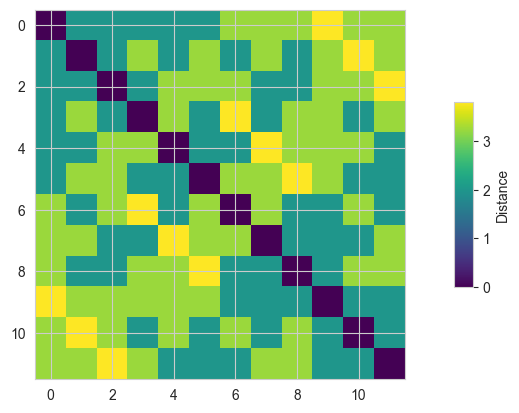

In [ ]:
distances = np.zeros((len(centers), len(centers)))

sorted_centers_arr = np.zeros((len(sorted_centers), 3))
for i, (x, y, z) in enumerate(sorted_centers):
    for j, (x2, y2, z2) in enumerate(sorted_centers):
        distances[i, j] = np.sqrt((x - x2) ** 2 + (y - y2) ** 2 + (z - z2) ** 2)
    sorted_centers_arr[i] = [x, y, z]

        
sc = plt.imshow(distances, cmap='viridis', interpolation='nearest')
plt.colorbar(sc, label='Distance', pad=0.1, aspect=10, shrink=0.5)

In [ ]:
x_indices + y_indices + z_indices

array([12, 24, 25,  6, 13, 12, 19, 13,  9, 14, 14, 19, 18,  7, 20, 16, 22,
       23, 22, 13, 19, 21, 17, 16, 13, 12, 27,  8,  9, 16])

In [ ]:
x_indices

array([ 0,  6,  5,  1,  1,  2,  5,  2,  1,  4,  2, 10, 11,  0,  8,  6, 10,
        8,  6,  8,  4,  8,  9,  5, 11,  9, 11,  2,  6, 11])

In [ ]:

# Create a grid of orientations based on the indices
orientations = np.array([[0, 45, 90, 135],
                         [180, 225, 270, 315],
                         [0, 45, 90, 135],
                         [180, 225, 270, 315],
                         [0, 45, 90, 135]])
# Assign orientations based on the indices
osi = orientations[x_indices, y_indices]

# osi = x * y * 360

sc = axs.scatter(x, y, z, c=osi, cmap='coolwarm', marker='o', s=35, alpha=1, )
plt.colorbar(sc, ax=axs, label='Orientation (degrees)', pad=0.1, aspect=10, shrink=0.2)

axs.scatter(0.5, 0.5, 0.5, c='royalblue', marker='x', s=100, alpha=1)

theta = np.linspace(0, 2 * np.pi, 1000)
phi = np.linspace(0, np.pi, 1000)
theta, phi = np.meshgrid(theta, phi)
r = 0.18

x = r * np.sin(phi) * np.cos(theta) + 0.5
y = r * np.sin(phi) * np.sin(theta) + 0.5
z = r * np.cos(phi) + 0.5

axs.plot_surface(x, y, z, cmap='Blues', alpha=0.5, linewidth=0, )

In [ ]:
mouse_id = 'M427836'
col_vol_str = '22'
plane = 3
plane_name = f"Plane_{plane}"

# DATA_DIR = Path("/home/roozbehf/Documents/v1dd_arefeh/V1_DD_NWBs/")
DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
DATA_DIR.resolve()
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")

dff_traces = session.get_traces(trace_type='dff', plane=plane)

In [ ]:
x_data = decoding.get_X_data(session, plane, "drifting_gratings_windowed") # T x N
y_data = decoding.get_Y_data(session, plane, "drifting_gratings_windowed", decode_dim="direction")

n1 = int(0.8 * x_data.shape[0])  # 80% of the data for training
x_train = x_data[:n1, :]
y_train = y_data[:n1]
x_test = x_data[n1:, :]
y_test = y_data[n1:]

knn, best_k = decoding.knn_cross_validation(15, "correlation", x_data, y_data)
knn.fit(x_train, y_train)
y_pred_train = knn.predict(x_train)
y_pred_test = knn.predict(x_test)

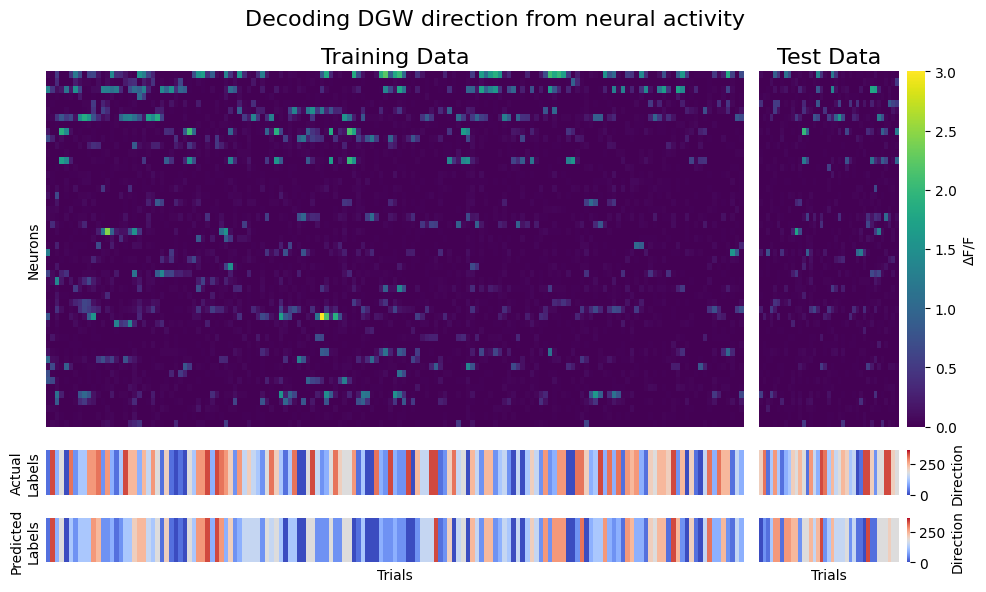

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 6), gridspec_kw={'height_ratios': [8, 1, 1], 'width_ratios': [4, 1]})

n1 = int(0.8 * len(y_data))

# plot subset of x_data (training data)
sns.heatmap(x_train.T[:50], 
            ax=axs[0][0], 
            cmap='viridis', 
            cbar_kws={'label': 'ΔF/F'}, 
            xticklabels=False, 
            yticklabels=False,
            vmin=0, vmax=3.0,
            cbar=False,
            )
axs[0][0].set_title('Training Data', fontsize=16)
axs[0][0].set_ylabel('Neurons')

# plot actual labels for training data
sns.heatmap(y_train.reshape(1, -1), 
            ax=axs[1][0], 
            cmap='coolwarm', 
            cbar_kws={'label': 'Direction'}, 
            xticklabels=False, 
            yticklabels=False,
            vmin=0, vmax=360,
            cbar=False,
            )
axs[1][0].set_ylabel('Actual\nLabels')

# plot predictions on training data
sns.heatmap(y_pred_train.reshape(1, -1),
            ax=axs[2][0], 
            cmap='coolwarm', 
            cbar_kws={'label': 'Direction'}, 
            xticklabels=False, 
            yticklabels=False,
            vmin=0, vmax=360,
            cbar=False,
            )
axs[2][0].set_xlabel('Trials')
axs[2][0].set_ylabel('Predicted\nLabels')


# plot subset of x_data (test data)
sns.heatmap(x_test.T[:50], 
            ax=axs[0][1], 
            cmap='viridis', 
            cbar_kws={'label': 'ΔF/F'}, 
            xticklabels=False, 
            yticklabels=False,
            vmin=0, vmax=3.0
            )
axs[0][1].set_title('Test Data', fontsize=16)

# plot actual labels for test data
sns.heatmap(y_test.reshape(1, -1), 
            ax=axs[1][1], 
            cmap='coolwarm', 
            cbar_kws={'label': 'Direction'}, 
            xticklabels=False, 
            yticklabels=False,
            vmin=0, vmax=360,
            )

# plot predictions on test data
sns.heatmap(y_pred_test.reshape(1, -1),
            ax=axs[2][1], 
            cmap='coolwarm', 
            cbar_kws={'label': 'Direction'}, 
            xticklabels=False, 
            yticklabels=False,
            vmin=0, vmax=360,
            )
axs[2][1].set_xlabel('Trials')

fig.suptitle("Decoding DGW direction from neural activity", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, 'decoding_analyses', f'dgw_decoding_example_{mouse_id}_{col_vol_str}_{plane_name}.svg'), dpi=300)

In [ ]:
from sklearn.model_selection import cross_val_score

Cross-validation scores: 0.52
Cross-validation scores: 0.15


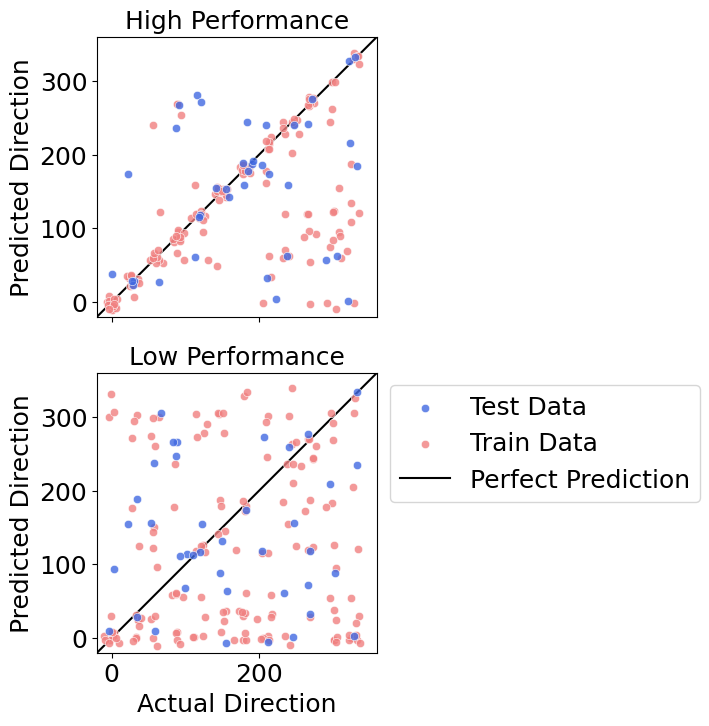

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(4, 8), sharex=True, sharey=True)

# first one is the same data as above
mouse_id = 'M427836'
col_vol_str = '22'
plane = 3
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")
x_data = decoding.get_X_data(session, plane, "drifting_gratings_windowed") # T x N
y_data = decoding.get_Y_data(session, plane, "drifting_gratings_windowed", decode_dim="direction")
n1 = int(0.8 * x_data.shape[0])  # 80% of the data for training
x_train = x_data[:n1, :]
y_train = y_data[:n1]
x_test = x_data[n1:, :]
y_test = y_data[n1:]
knn, best_k = decoding.knn_cross_validation(15, "correlation", x_data, y_data)
knn.fit(x_train, y_train)
y_pred_train = knn.predict(x_train)
y_pred_test = knn.predict(x_test)
cross_val_scores = cross_val_score(knn, x_data, y_data, cv=5)
print(f"Cross-validation scores: {np.mean(cross_val_scores):.2f}")

noise = 5
y_test = [y + np.random.normal(0, noise) for y in y_test]  # Adding some noise to test data for visualization
y_train = [y + np.random.normal(0, noise) for y in y_train]  # Adding some noise to training data for visualization
y_pred_test = [y + np.random.normal(0, noise) for y in y_pred_test]  # Adding some noise to predicted test data for visualization
y_pred_train = [y + np.random.normal(0, noise) for y in y_pred_train]  # Adding some noise to predicted training data for visualization
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.8, color='royalblue', ax=axs[0], zorder=2)
sns.scatterplot(x=y_train, y=y_pred_train, alpha=0.8, color='lightcoral', ax=axs[0], zorder=1)
axs[0].plot([-50, 400], [-50, 400], color='black', linestyle='-', linewidth=1.5, alpha=1, zorder=0)
axs[0].set_xlim(-20, 360)
axs[0].set_ylim(-20, 360)
axs[0].set_xlabel('Actual Direction', fontsize=18)
axs[0].set_ylabel('Predicted Direction', fontsize=18)
axs[0].set_title(f'High Performance', fontsize=18)
axs[0].set_aspect('equal', adjustable='box')
axs[0].tick_params(axis='both', which='major', labelsize=18)

mouse_id = 'M427836'
col_vol_str = '21'
plane = 1
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")
x_data = decoding.get_X_data(session, plane, "drifting_gratings_windowed") # T x N
y_data = decoding.get_Y_data(session, plane, "drifting_gratings_windowed", decode_dim="direction")
n1 = int(0.8 * x_data.shape[0])  # 80% of the data for training
x_train = x_data[:n1, :]
y_train = y_data[:n1]
x_test = x_data[n1:, :]
y_test = y_data[n1:]
knn, best_k = decoding.knn_cross_validation(15, "correlation", x_data, y_data)
knn.fit(x_train, y_train)
y_pred_train = knn.predict(x_train)
y_pred_test = knn.predict(x_test)
cross_val_scores = cross_val_score(knn, x_data, y_data, cv=5)
print(f"Cross-validation scores: {np.mean(cross_val_scores):.2f}")

y_test = [y + np.random.normal(0, noise) for y in y_test]  # Adding some noise to test data for visualization
y_train = [y + np.random.normal(0, noise) for y in y_train]  # Adding some noise to training data for visualization
y_pred_test = [y + np.random.normal(0, noise) for y in y_pred_test]  # Adding some noise to predicted test data for visualization
y_pred_train = [y + np.random.normal(0, noise) for y in y_pred_train]  # Adding some noise to predicted training data for visualization
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.8, color='royalblue', label='Test Data', ax=axs[1], zorder=2)
sns.scatterplot(x=y_train, y=y_pred_train, alpha=0.8, color='lightcoral', label='Train Data', ax=axs[1], zorder=1)
axs[1].plot([-50, 400], [-50, 400], color='black', linestyle='-', linewidth=1.5, alpha=1, zorder=0, label='Perfect Prediction')
axs[1].set_xlim(-20, 360)
axs[1].set_ylim(-20, 360)
axs[1].set_xlabel('Actual Direction', fontsize=18)
axs[1].set_ylabel('Predicted Direction', fontsize=18)
axs[1].set_title(f'Low Performance', fontsize=18)
axs[1].tick_params(axis='both', which='major', labelsize=18)
axs[1].set_aspect('equal', adjustable='box')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=18)
# plt.tight_layout()

plt.savefig(os.path.join(ARTIFACT_DIR, 'decoding_analyses', f'dgw_decoding_example_scatter_{mouse_id}.svg'), dpi=300)